# Homework 04 - Applied ML

*Remarks for the easy reading of the work*:
The data in use are stored in the folder `Data`, the description is available [here](https://github.com/ADAEPFL/Homework/blob/master/04%20-%20Applied%20ML/DATA.md).
All the functions that are mentioned are stored in separate libraries that are specified at each step. For some of them the reading of the documentation is required to understand how certain results are obtained. 
The *Notebook* organisation is specified in the *Table of contents*.

__Important__: due to the precence of interactive plot, we suggest you to visualize the notebook using the following [link](http://nbviewer.jupyter.org/github/CriMenghini/ADA_Homeworks/blob/master/Homework_4/Hw_4.ipynb).

### Table of contents
1. [Predict the skin color of a soccer player](#task1)
    1. [Exploratory Data Analysis, Feature Selection and Feature engineering](#EDA)
     1. [Target variable](#target)
     2. [Features](#features)
    2. [Baseline model](#baseline)
     1. [Preprocess variable to be used as input for the classifier](#preproc)
     2. [Split train and test](#split)
	3. [Find the model](#tuning)
     1. [Cross-validation for tuning parameters](#cvtuning)
     2. [Cross-validation to assess the quality of the model](#cvmodel)
    4. [Features importance](#impfeat)
    5. [Balance the sample, create many regressors and then average the models](#balance)
	6. [*BONUS*](#bonus)
2. [Cluster players with dark and light skin colors](#task2)
    1. [Sub paragraph](#subparagraph1)

## 1. Predict the skin color of a soccer player <a name="task1"></a>

In this first task we train a *Random forest* classifier to be able to predict the skin color of a soccer player using the player description. In order to do so, we proceed pre-processing the data as first step then moving toward the choice of the model (interpret as the choice of parameters controlling the possible issues i.e. the *overfitting*). As required, we then switch to the inspection of the `feature_importances_` attribute and the discussion of the obtained results.

In [1]:
import plotly
import warnings
import numpy as np
import pandas as pd
from plots import *
import plotly.tools as tls
from sklearn import metrics
from balance_sample import *
from functools import partial
import matplotlib.pyplot as plt 
from data_preprocessing import *
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, cross_val_score
warnings.filterwarnings('ignore')
plotly.tools.set_credentials_file(username='crimenghini', api_key='t5q05yuxzu')
plotly.tools.set_credentials_file(username='cristina.crocca', api_key='l1up4iv6pj')
%matplotlib inline

In [21]:
# Import data 
data = pd.read_csv('Data/CrowdstormingDataJuly1st.csv', sep = ',')
# Take a look at the data head
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


### A. Exploratory Data Analysis, Feature Selection and Feature engineering <a name="EDA"></a>

### a. Target variable <a name="target"></a>

Before proceeding with the exploration of the features, we focuse our attention on the target variable (`rater1`, `rater2`). In this case we face the folliwing issues:
1. [*Absence of labels*](#absence): Not all the players have an `IDphoto`, thus the *raters* can not label the skin color. It results in a bunch of player not labeled. Since in this first task we work using the *Supervised* learning we drop out all the *dyads* that correspond to players whose picture is not available.

2. [*Inconsistency of labels*](#inconsistency): The labels assigned by the two raters for some players disagree. In order to control this inconsistency we think about different approaches. 
    - Compute the mean of the assigned scores. Whether the classification problem is set up as a *multiclassification* problem (five classes according to the `data description` - 0, 0.25, 0.5, 0.75, 1), if the disagreement of the two classes is greater than 0.25 (absolute value) the computation of the average implies the creation of new classes. Otherwise, whether the classification problem is simplified to the *binary* classification (all those players that have been labeled with $0 < values \leq 0.5$ belong to class 0, all those whose $0.5 < values \leq 1$) the values obtained computing the average can be easily assigned to one of the two classes.
    - Use the two scores vectors to train the model, defining a *multi target* model whether the problem is set up both as *multiclass* or *binary*.
        
3. [*Unbalanced sample*](#unbalance): the sample that we analyse turns to be *unbalanced*. It means that there are classes that are more present in the population. This verification leads to the necessity of using different metrics, rather the *simple* accuracy, to evaluate the model, and can be in some way faced using some tecniques to *rebalance* the sample.

#### 1. Absence of labels  <a name="absence"></a>

In [22]:
# Drop out the unlabeled players
data_clean = data[(data.photoID.notnull())]

Now we are left with the data for the players that have a picture. We want to check whether given the picture both of the raters assuigned the label.

In [23]:
# How many players the rater 1 don't label?
miss_rater_1 = sum(data_clean.rater1.isnull())
# How many the rater 2?
miss_rater_2 = sum(data_clean.rater2.isnull())

print ('Rater 1 does not label', miss_rater_1, 'players')
print ('Rater 2 does not label', miss_rater_2, 'players')

Rater 1 does not label 0 players
Rater 2 does not label 0 players


We see that both of them label all the players with a picture.

#### 2. Inconsistency of labels <a name="inconsistency"></a>

##### 2.1. Handle `NaNs`
Before analysing the *target* we should control whether there is the precence of `NaN` values, that can eventually lead to the elimitation of players, in the dataset, then we *aggregate* by the player. It is important to check the precence of null values before the aggregation for two reasons:
* It is possible that some dyads do not contain certain values, it does not imply that in the dataset we can not find other dyads that contain the information. Hence, we remove the dyads or, if possible, assign the value (according to the kind of attribute) so that we don't loose the player.
* The precence of `NaN` can cause problems whether an aggregation function is applied. That's because they may propagate.

In [24]:
# Initialize the dictionary {key:value} whose key is the attributed with NaNs and value are the indices
variables_with_nan = {}

# For each attribute
for attribute in data_clean.columns:
    # Check if there are nans
    index_nan = data_clean[attribute].isnull()
    presence_nan = sum(index_nan)
    
    if presence_nan != 0:
        variables_with_nan[attribute] = index_nan

Here the variables with `NaNs` is listed. 

In [25]:
print(variables_with_nan.keys())

dict_keys(['weight', 'nIAT', 'Alpha_3', 'meanExp', 'seExp', 'meanIAT', 'height', 'seIAT', 'nExp', 'position'])


We proceed considering the attributes related to the players: `weight`, `height`, `position`.

In [26]:
players_attributes = ['weight', 'height', 'position']

Thus, we clean the dataframe, the documentation related to the function [`remove_nans`](data_preprocessing.py) provides the explanation related to the procedure used to remove `NaNs`.

In [27]:
data_clean = remove_nans(data_clean, variables_with_nan, players_attributes)

We remove ~21% of the dyads, but the number of drop player is controlled by the approach used to remove the `NaNs`. In fact we remove just those player whose important description feature are missing.

In [28]:
print ('Number of removed dyads: ', data.shape[0] - data_clean.shape[0])
print ('Percentage of the removed dyads: ', round((data.shape[0] - data_clean.shape[0])/len(data)*100,2), '%')

Number of removed dyads:  30425
Percentage of the removed dyads:  20.84 %


Then, we aggregate by player and we observe that we proceed the analysis taking into account ~90% of the players.

In [29]:
# Group by the player
player_data = data_clean.groupby('playerShort')

In [30]:
print ('Number of players: ', len(player_data))
print ('Percentage of analysed players: ', round(len(player_data)/1586*100, 2), '%')

Number of players:  1419
Percentage of analysed players:  89.47 %


Before using the aggregation functions for some attributes we check whether aggregating we risk to loose some information.

In [31]:
# Check that each player belongs to one club
print ('Each player belongs to: ', player_data.agg({'club' : lambda x: len(set(x))})['club'].unique()[0], 'club.')
# Check that each player registers one position
print ('Each player registers:', player_data.agg({'position' : lambda x: len(set(x))})['position'].unique()[0], 'position.')
# Check that each player registers one weight
print ('Each player registers: ', player_data.agg({'weight' : lambda x: len(set(x))})['weight'].unique()[0], 'weight.')
# Check that each player registers one height
print ('Each player registers: ', player_data.agg({'height' : lambda x: len(set(x))})['height'].unique()[0], 'height.')

Each player belongs to:  1 club.
Each player registers: 1 position.
Each player registers:  1.0 weight.
Each player registers:  1.0 height.


In [32]:
# Define the aggregation function
players = player_data.agg({'club' : 'first',
                           'leagueCountry' : 'first',
                           'birthday' : 'first',
                           'height' : 'first',
                           'weight' : 'first',
                           'position' : 'first',
                           'games' : 'sum',
                           'victories' : 'sum',
                           'ties' : 'sum',
                           'defeats' : 'sum',
                           'goals' : 'sum',
                           'yellowCards': 'sum',
                           'yellowReds': 'sum',
                           'redCards' : 'sum',
                           'rater1' : 'mean',
                           'rater2' : 'mean',
                           #'refNum' : 'count',
                           #'refCountry' : 'count',
                           #'meanIAT' : 'mean',
                           #'meanExp' : 'mean'
                          })

In [34]:
columns = ['club', 'leagueCountry', 'birthday', 'height', 'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards', 'rater1', 'rater2']
players = players[columns]
players.head()

,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,rater1,rater2
playerShort,,,,,,,,,,,,,,,,
aaron-hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,654,247,179,228,9,19,0,0,0.25,0.00
aaron-hunt,Werder Bremen,Germany,04.09.1986,183.0,73.0,Attacking Midfielder,336,141,73,122,62,42,0,1,0.00,0.25
aaron-lennon,Tottenham Hotspur,England,16.04.1987,165.0,63.0,Right Midfielder,412,200,97,115,31,11,0,0,0.25,0.25
aaron-ramsey,Arsenal FC,England,26.12.1990,178.0,76.0,Center Midfielder,260,150,42,68,39,31,0,1,0.00,0.00
abdelhamid-el-kaoutari,Montpellier HSC,France,17.03.1990,180.0,73.0,Center Back,124,41,40,43,1,8,4,2,0.25,0.25


##### 2.2. Analyse the target  <a name="rater12"></a>

From the new dataframe we extract the two variables that correspond to the labels.

In [35]:
# Extract labels
label_1 = players['rater1']
label_2 = players['rater2']

We observe that the distribution of the labels related to the two raters are different. It shows the disagreement aforementioned. In particular, the first classifies the 75% of the players as *very light skin*, *light skin*, the number of players classified as *dark skin* or *very dark skin* is so low that the are outside the *Inter-Quartile Range*. The second rated evidence the tendency of giving higher scores. Since we do not have another rater to compare, we can't make an assumption on the reliability of the two.

In [36]:
#boxplot_raters(label_1, label_2)
tls.embed('https://plot.ly/~cristina.crocca/27')

#### 3. Unbalanced sample <a name="unbalance"></a>

In the view of what we observed in the [previous](#rater12) section, we see that our sample suffers of the lack of samples that are recognized as *dark skin* or *very dark skin*. We show more clearly with the following plot the unbalancement. In particular we see that both the *Rater 1* and *Rater 2* classify in the first three classes more than the 50%.

In [39]:
#stacked_plot(label_1,label_2)
tls.embed("https://plot.ly/~cristina.crocca/29")

This verification implies important consideration for the further analysis. 
1. We redifine the goal of our analysis as a *Binary Classification* problem. We consider it enough to distinguish a "light skin" player from a "dark skin". In particular the Labels are encoded according to the intervals defined [above](#target). This choice can help us in facing the *unbalancement* of our sample and reduce the complexity of our classification problem. 
2. So far we used the *Accuracy* metric in order to evaluate the accuracy of the model. We will replace it with some other metric. The reason behind it comes from the definition of the accuracy. It is a ratio of the correct prediction over the total sample to predict. Due to the presence of a class (*light skin*) that represents the majority in the sample, the classifier is able to classify this class well. In particular it tends to classify all the observation as that class (we will look at the confusion matrices later). Thus, the accuracy results to be very good just because of the high precence of the class in the data.

Thus, we encode the labels according to the binary classification problem. Before encoding the labels we merge the rates given by the two raters by averaging the scores. The function is stored in [`data_preprocessing`](data_preprocessing.py) library.

In [40]:
label_merged = (label_1 + label_2)/2
labels = label_merged.apply(binary_labels)

In [41]:
players.drop('rater1', axis = 1, inplace = True)

In [42]:
players.drop('rater2', axis= 1, inplace = True)

### b. Features <a name="features"></a>

Now we focuse on the study of the other features in our dataset. In particular, for the moment we avoid to take into account the information related to the [referee](#referee) (features realated to the `IAT` and `Exp`, `refCountry`).
In an ideal world, where the racism is not present on a soccer's field, the [phisical characteristics](#physical) of a player (and the features that derives from them) should be the only really useful to classify a player as black or white. 

#### Physical features <a name="physical"></a>

In particular, the following plot tries to visualize how some features vary according to the the skin color of a player. We choose as features to plot:
- `leagueCountry`: It may be possible that in some leagues there is an higher presece of players with different skin colors.
- `club`: Some clubs may decide to buy players according to the physical characteristics of players with *light* or *dark* skin color.
- `yellowCards`: We focuse on the average number of yellow cards registered in each team. 
- `weight`, `height`: Physical characteristics. It may be plausible that *light* skin soccer players have different pysical characteristics respect the *dark* skin ones.

Each bubble represents a `club`. The diameter of the bubbles shows the proportion of *dark* skin players in the club. The colour of the bubbles corresponds to the `League` the club is part of. The legend shows different sizes, bigger is the point greater is the average percentage of *dark* players in the `League`. The pop-up of each bubbles describe the characteristics of the `club`. It is important to notice that there are few bubbles that result to be extramly big and that register the 100% presence of *dark* skin players, just because he is the only player in the team!

In [43]:
#bubble_plot(labels, players, 'yellowCards', 'mean', 'weight', 'mean', 'height', 'mean')
tls.embed("https://plot.ly/~cristina.crocca/0")

The plot is interesting. We can infer that knowing the League which the player belongs may be a good variable for our model. Taking a look at the bubbles of the same color, we see that the clubs whose proportion of *dark* skin players is similar tend to have similar values related to the average height and weight. Respect the number of `Yellow cards`, using the pop-ups, we are not able to find a kind of *path* toward the skin color.

#### Referee features <a name="referee"></a>

The first thing that we inspect is the distribution of the average `meanIAT` and `meanExp`. We infer that the average `meanIAT` and `meanExp` of the referees who umpire the games of *light* skin players tend to have higher values. We do not think that the features related to this scores should be part of our model.

In [44]:
#boxplot_plotly(players, labels, 'meanIAT')
tls.embed('https://plot.ly/~cristina.crocca/6')

In [45]:
#boxplot_plotly(players, labels, 'meanExp')
tls.embed('https://plot.ly/~cristina.crocca/9')

We check whether a relationship between the number of yellow cards obtained by a player (by making the distrinction between *light* and *dark* skin) appears to be, in some sense, dependent on the average of the `meanIAT` values of all the referee a player play with. As shown in the plot below, it is not possible to identify a real path.

In [46]:
# scatter_plot(players, labels)
tls.embed('https://plot.ly/~cristina.crocca/13')

### B. Baseline model  <a name="baseline"></a>

The first model than we consider takes as inputs all the variables except the `refNum`, `refCountry`, the standard deviation of `meanIAT` and `meanExp` and the cardinality of the population the information (related to the latter features) have been inferred.

Before feeding the model with the features, we proceed as follows:

1. We [preprocess](#preproc) the different features:
 1. Birthday: just keep the year
 2. Categorization of numerical features when they present more than 12 different values
 3. Encoding of the 'object' attributes according to what is required by the `sklearn`'s `RandomForest` classifier.

2. We [split](#split) the entire data into train and test set (respectively 80% and 20%).

#### Preprocess variable to be used as input for the classifier  <a name="preproc"></a>

The procedures used to preprocess the data are wrapped in functions sored in the [`data_preprocessing`](data_preprocessing.py) library. Inside the function is provided the documentation to understand what we do.

In [47]:
# Keep only the year of the birthday
players['birthday'] = players['birthday'].apply(lambda x: float(x.split('.')[-1]))

In [48]:
# Get the string variables
object_features = [i for i in players.columns if players[i].dtypes == 'object']
print ('Object features: ', object_features)


# Get the list of the numerica variables
numerical_features = [i for i in players.columns if (players[i].dtypes == 'int64' or players[i].dtypes == 'float64') and len(players[i].unique()) > 12]
print ('Numerical features: ',numerical_features)

Object features:  ['club', 'leagueCountry', 'position']
Numerical features:  ['birthday', 'height', 'weight', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards']


In [49]:
# Encode string variables
for feature in object_features:
    encode_string_variable(players, feature)

In [50]:
# Categorise the numerical features
for i in range(len(numerical_features)):
    players[numerical_features[i]] = players[numerical_features[i]].apply(partial(categorisation, create_bins(players, numerical_features[i])))

Take a look at the pre-processed dataframe.

In [51]:
players.sample(5)

,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards
playerShort,,,,,,,,,,,,,,
fabian-orellana,36,3,8,5,4,11,4,3,4,5,1,3,3,5
carlton-cole,88,0,7,18,10,2,6,4,7,8,3,3,1,2
roel-brouwers,15,2,5,19,8,1,5,3,6,5,0,3,3,4
leon-balogun,32,2,9,18,8,1,2,1,3,3,0,2,0,1
sylvain-distin,26,0,3,19,9,1,9,7,11,11,0,4,1,1


#### Split train and test  <a name="split"></a>

In [52]:
# Split train and test
X_train, X_test, y_train, y_test = train_test_split(players, labels, test_size=0.20, random_state=42)

Due to the fact that our sample is [unbalanced](#unbalance), we try to mitigate its effect exploiting some `sklearn` [spells](http://gph.is/1sGDBKR). In particular, we provide to the model the weigths of the two classes inside the train population, in such a way that it uses it during the training. The code is provided in the [`balance_sample`](balance_sample.py) library.

In [53]:
# Compute the sample weights of the train
sample_weights = weight_sample(y_train)

Hence, we setu up our classifier. For the *baseline* model we do not care about the parameters.

In [54]:
forest = RandomForestClassifier(n_estimators=100, random_state=1, class_weight='balanced')

Then, we train the classifier!

In [55]:
train_forest = forest.fit(X_train, y_train, sample_weight= sample_weights)

And get the predictions!

In [56]:
predict = train_forest.predict(X_test)

At first we get the *accuracy* of the model..

In [57]:
print ('Accuracy of the model: ', metrics.accuracy_score(y_test, predict))

Accuracy of the model:  0.841549295775


Putting no efforts the classifere already returns a good level of accuracy, that is the proportion of *True positive* and *True false* over the all population to predict. To be sure that the accuracy is a good metric to consider we take a look at the confusion matrix <a name="confmatr"></a>.

In [58]:
print ('Confusion matrix: \n',
       metrics.confusion_matrix(y_test, predict))

Confusion matrix: 
 [[236   3]
 [ 42   3]]


As we see the classifier is able to classify correctly almost all the players with *Light* skin, but it commits a lot of mistakes in the classification of the *Dark* skin players. Infact only a little portion is correctly classified  (recall score considering the *Dark skin* as the positive value).

In [59]:
print ('Recall for the Dark skin class: ', metrics.recall_score(y_test, predict))

Recall for the Dark skin class:  0.0666666666667


This verification suggests us that, due to the unbalance of the sample, the accuracy is not the most appripriate way to measure the quality of our model. So we use as metrics the ROC-AUC <a name="roc_auc"></a> score and the [F_BETA](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html) that is the weighted harmonic mean of precision and recall. In particular we assign to *beta* a value greater than 1 to give more relevance to the *recall*, in order to check whether our classifier is aslso able to recognize the *dark* skin.

In [60]:
print ('AUC : ',metrics.roc_auc_score(y_test, predict))

AUC :  0.527057182706


The values of the AUC shows that our classifier is not so far from a random classifier!!

In [61]:
print ('F beta : ', metrics.fbeta_score(y_test, predict, beta=1.9))

F beta :  0.0821015138023


The metric above gets value between 0 and 1. Its optimal value is 1 and its worst value is 0. We can't definitely say the our estimator is good enough!

### C. Find the model <a name="tuning"></a>

Now we proceed with the cross-validation to do two things:
1. Tuning the parameters *max_depth* and *n_estimators*, namely we want to control how the model behaves when we reduce or increase its complexity.
2. We run a simple cross-validation to check the quality of the classifier with different data points.

#### 1. Cross-validation for tuning parameters <a name="cvtuning"></a>

The run CV is a *K-folders* where K=10. The function used is the [`tuning_cv`](balance_sample.py), the documentation inside the library provides all the information about the implemented procedure. It recalls the [`cross_validation`](balance_sample.py) that we implemented from scratch in order to get additional information like the train "accuracy" and the standard deviation of both the *train* and *test* "accuracy".

In [62]:
average_roc_train, std_roc_train, average_fbeta_train, std_fbeta_train, average_roc_test, std_roc_test, average_fbeta_test, std_fbeta_test, couples_estimators = tuning_cv(players, labels, list_depths = range(4,50, 5), list_numbers_estimators = range(4,100, 5)) 

Thus, for each combination of `depth` and `number of estimators` we plot the average AUC and Fbeta obtained during the *CV*.

In [63]:
#train_test_plot(couples_estimators, average_roc_train, average_roc_test, average_fbeta_train, average_fbeta_test, plot_name='train_test')
tls.embed('https://plot.ly/~cristina.crocca/19')

Look at the graph we clearly see that our classifier overfits. The train error is always a way higher than the test error. Our model is too complex. We can notice a decreasing trend for the test *AUC* and *Fbeta* that shows that increasing the depth and the number of estimators of the classifiers (increasing the complexity of the model) we continue to reduce the bias in the model making it too sticky to the train data points and inducing a lack of generality. Moreovere, looking at the AUC scores, again, our model doesn't seem to be way better than a random classifier!!!

Anyway, we have to choose the parameters that we want to use for our output model. We prefer those whose FBeta is higher. But before making the final choice we also take a look at the standard deviations of test FBeta. In particular, for the sake of the graph interpretation, we get focused on the first 30 combinations of parameters.

In [64]:
#error_bars(couples_estimators[:30], average_fbeta_test[:30], std_fbeta_test[:30])
tls.embed('https://plot.ly/~cristina.crocca/23')

Thus, the parameters that we choose are `n_estimators`=9 and `max_depth`=24 (corresponding to the 14th combination). From the plot above we can see that, even if the variance of the *Fbeta* obtained during the *CV* is higher than the other group of *parameters couple* (from 4 to 9), the possible values of the *FBeta* are still better.

#### Cross-validation to assess the quality of the model <a name="cvmodel"></a>

Then, we run the *CV* to see the scores obtained by our model. In particular, we fit the classifier on the train and test sets used [above](#split).

In [65]:
# Fefine the classifier
forest = RandomForestClassifier(n_estimators=9, max_depth=24, random_state=1, class_weight='balanced')

# Cross validation
n_fold = 10
cv_scores = cross_val_score(forest, X_train, y_train, cv=n_fold, scoring='f1')

In [68]:
plot_cv_scores(n_fold, cv_scores)
tls.embed('https://plot.ly/~cristina.crocca/31')

In [69]:
print ('On average, the F score in the 10-folds is :', np.mean(cv_scores), '. The model has still too low bias.')

On average, the F score in the 10-folds is : 0.185518288475 . The model has still too low bias.


### Features importance <a name="impfeat"></a>

We now move to the evaluation of the features in the model.

In [70]:
# Fit the model
forest.fit(X_train, y_train)
# Compute the features importance
importances = forest.feature_importances_

In [73]:
#plot_features_importance(players, importances)
tls.embed('https://plot.ly/~crimenghini/4')

We can happily announce that our beloved [`pandas`](http://gph.is/1LLTeqz) wins its battle against racism! In fact, in our model, the features related to the behaviour of the referees are not as important as the ones that refer to the *"description"* of a player. So, whether we would be interested in performing the model with few input features, we could do it using those related only to the players.

### E. Balance the sample, create many regressors and then average the models  <a name="balance"></a>

Due to the high effects that the composition of the sample has on the performances of our model, we decide to proceed as follow (the procedure is applied on the train, the test will be used later to perform the model).

1. [Classes presence in the train data set](#class) We observe that the weights of the train set are ~84% for the *light skin* and ~16% for the *dark skin*
2. [Create the  data sets which the model will be run on](#create) We create M new dataframe that will have the two classes in an equal proportion. 
3. [Train each classifier and make prediction](#train) We run a Random Forest to each dataset, then we compute the prediction.
4. [Average the models](#average): voting procedure.

##### 1. Classes presence in the train data set <a name="class"></a>

In [138]:
# Compute the number of players present in the two classes
weight_class = y_train.value_counts()
print (weight_class)

0    953
1    182
dtype: int64


##### 2. Create the  data sets which the model will be run on <a name="create"></a>

In order to create the data sets we proceed as follows:

In [139]:
# Distinguish between the dataframe that corresponds to the "light" skin and the "dark" skin classes
X_class_0 = X_train[y_train == 0]
X_class_1 = X_train[y_train == 1]

From the `X_class_0` we extract a 5 (proportion of *light* on *dark*) random samples. Each of this sample is concatenated to the `X_class_1`. Thus, we have 5 *"homogeneous"* (balanced) datasets which our model will be fit on.

In [140]:
# Randomly draw the indexes of the X_class_0 samples which will compose the new dfs
indexes = users_chunks(int(weight_class[0]/weight_class[1]), np.random.permutation(X_class_0.shape[0]))

Thus, we proceed creating the dataframes.

In [141]:
X_1, y_1_train, X_2, y_2_train, X_3, y_3_train, X_4, y_4_train, X_5, y_5_train =  create_df(X_class_0, X_class_1, y_train, indexes, n_df=5)

##### 3. Train each classifier and make prediction  <a name="train"></a>

For the sake of our readers, we are not going to optimize the predictions of our model. In fact, our purpose is just to show that this kind of approach can control better the unbalancement present in our data. Hence, we are going to set the same parameters for each forest. We try to avoid to create models that are to complex, in order to avoid the overfitting. Moreover, we run a 10-fold cross validation to see how the classifier behaves with different points.

In [161]:
# Define the forest
forest = RandomForestClassifier(n_estimators=40, max_depth=10 ,random_state=1)

# Compute the CV on X1
f1_score_X1 = cross_val_score(forest, X_1, y_1_train, cv=10, scoring='f1')

# Compute the CV on X2
f1_score_X2 = cross_val_score(forest, X_2, y_2_train, cv=10, scoring='f1')

# Compute the CV on X3
f1_score_X3 = cross_val_score(forest, X_3, y_3_train, cv=10, scoring='f1')

# Compute the CV on X4
f1_score_X4 = cross_val_score(forest, X_4, y_4_train, cv=10, scoring='f1')

# Compute the CV on X5
f1_score_X5 = cross_val_score(forest, X_5, y_5_train, cv=10, scoring='f1')

In [131]:
# Plot the results
#balance_cv_plot(f1_score_X1, f1_score_X2, f1_score_X3, f1_score_X4, f1_score_X5, n_fold = 10)
tls.embed('https://plot.ly/~crimenghini/16')

Comparing these results with the once obtained before we see that each classifier results to be much metter than the one computed [before](#cvmodel).

Then, we obtain the predictions for each classifier for the test set.

In [162]:
# Train classifier 1
train_forest = forest.fit(X_1, y_1_train)
# Obtain predictions
predict_1 = train_forest.predict(X_test)

# Train classifier 2
train_forest = forest.fit(X_2, y_2_train)
# Obtain predictions
predict_2 = train_forest.predict(X_test)

# Train classifier 3
train_forest = forest.fit(X_3, y_3_train)
# Obtain predictions
predict_3 = train_forest.predict(X_test)

# Train classifier 4
train_forest = forest.fit(X_4, y_4_train)
# Obtain predictions
predict_4 = train_forest.predict(X_test)

# Train classifier 5
train_forest = forest.fit(X_5, y_5_train)
# Obtain predictions
predict_5 = train_forest.predict(X_test)

##### 4. Average the models <a name="average"></a>

We average the outputs of the three classifiers using the voting procedure. Namely, we look at the predictions of all the estimator for each player and then we classify him with the lables with the highest occurrences. The functions are provided in [the library](balance_sample.py).

In [163]:
# Create a dataframe of prediction (rows: classifiers, columns: players)
prediction_df = pd.DataFrame([predict_1.T, predict_2.T, predict_3.T, predict_4.T, predict_5.T])
prediction_df.head()

,0,1,2,3,4,5,6,7,8,9,...,274,275,276,277,278,279,280,281,282,283
0,0,1,0,0,0,1,1,1,1,1,...,1,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,1,1,1,1,0,...,0,0,1,0,0,0,1,0,0,0
3,0,1,0,0,0,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,1,1,0,1,...,1,0,0,0,0,0,1,1,0,0


In [164]:
# Apply the voting procedure
average_model_predictions = voting_procedure(prediction_df)

Comparing the just obtained results to those obtaines before we see that we obtain considerable improvments if we take a look at the [confusion matrix](#confmatr). In fact we see that now the classifier is better in recognizing the *Dark* skin players, and it does not just point to the class of *light* skin color.

In [169]:
print ('Confusion matrix: \n',
       metrics.confusion_matrix(y_test, average_model_predictions))

Confusion matrix: 
 [[173  66]
 [ 23  22]]


Finally, we compare also the AUC and the Fbeta with the ones obtained [above](#roc_auc). We observe a quite satisfing improvements.

In [170]:
print ('AUC : ', metrics.roc_auc_score(y_test, average_model_predictions))

AUC :  0.606369130637


In [171]:
print ('F beta : ', metrics.fbeta_score(y_test, average_model_predictions, beta=1.9))

F beta :  0.404951088042


### *BONUS* <a name="bonus"></a>

We would like to test the parameters for the *RandomForestClassifier* in order to obtain the view of the bias and variance in the train and test data. We are going to draw the learning curves. We will use cross-validation with 20 folds.

We will first see the curve that shows the parameters for the RandomForest (values for n_estimators and max_depth) that leads it to overfit the training set. We can see that the curves are far away from each other. The model is so complex that even increasing the set of samples doesn't change its performance. Especially for the test dataset it doesn't improve the prediciton.

<module 'matplotlib.pyplot' from '/Users/cristinamenghini/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py'>

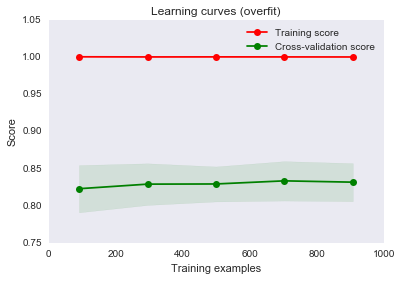

In [172]:
plot_learning_curve(RandomForestClassifier(n_estimators=75, max_depth=75), 'Learning curves (overfit)', X_train, y_train, cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0))

Then to contrary we will show the set of parameters that decreases the performance of the classifier and leads to high bias. On the other hand such model is more general. We can observe loss of accuracy for the training set the more samples we take the worst performance we have. But in parallel we get the stable prediction for the test dataset. We see that having large sample accuracy curves of train and test sets get closer. It means that our model tends to be more reusable. Having such general model prevents us from overfitting and leads to better practical applications.

<module 'matplotlib.pyplot' from '/Users/cristinamenghini/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py'>

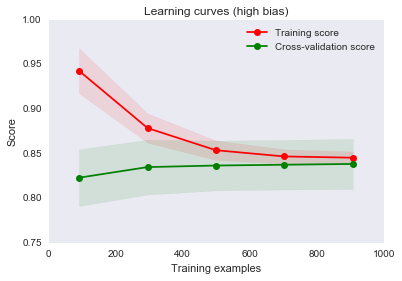

In [173]:
plot_learning_curve(RandomForestClassifier(n_estimators=15, max_depth=5), 'Learning curves (high bias)', X_train, y_train, cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0))

## 2. Cluster players with dark and light skin colors <a name="task2"></a>